In [8]:
from neo4j import GraphDatabase

def get_neo4j_driver(uri, user, password) -> GraphDatabase.driver:
    return GraphDatabase.driver(uri, auth=(user, password))

uri = "neo4j+s://9d1381c2.databases.neo4j.io:7687"  # my uri
user = "Wesley"  # my user name
password = "Xlbabv969."  # my password
driver = get_neo4j_driver(uri, user, password)


In [9]:
query = "MATCH (n) RETURN COUNT(n) AS node_count"  # Your query
node_count = 0
with driver.session() as session:
    result = session.run(query)
    for record in result:
        node_count = record["node_count"]  # Extract the node count

print(f"Total number of nodes: {node_count}")


ValueError: Cannot resolve address 9d1381c2.databases.neo4j.io:7687

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

with driver.session() as session:
    result = session.run("MATCH (n) RETURN n, labels(n) AS labels")
    for record in result:
        node_id = record["n"].element_id  
        labels = record["labels"]
        G.add_node(node_id, labels=labels)

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=False, node_size=50, node_color="skyblue", font_size=8)
plt.title("Neo4j Graph Visualization")
plt.show()

driver.close()

                

ValueError: Cannot resolve address 9d1381c2.databases.neo4j.io:7687

In [9]:
!pip install dash

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd


In [23]:
query = """
MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)
RETURN p.name AS Product, r.name AS Recipe
"""

product_data = []  # Initialise an empty list to store all records

with driver.session() as session:
    result = session.run(query)
    for record in result:
        product_data.append(record.data())  # Add each record to the list

df = pd.DataFrame(product_data)  # Converts the entire list into a DataFrame
print(df)


                                               Product Recipe
0       Coca - Cola Classic  Soft Drink Multipack Cans   None
1       Coca - Cola Classic  Soft Drink Multipack Cans   None
2       Coca - Cola Classic  Soft Drink Multipack Cans   None
3            Coca - Cola Classic  Soft Drink Mini Cans   None
4       Coca - Cola Vanilla  Soft Drink Multipack Cans   None
..                                                 ...    ...
110                Woolworths Apple In Pineapple Jelly   None
111                Goulburn Valley Two Fruits In Juice   None
112                     Dole Pineapple Slices In Syrup   None
113                     Dole Pineapple Chunks In Juice   None
114  Goulburn Valley Two Fruits In Juice Fruit Cups...   None

[115 rows x 2 columns]


In [27]:
query = """
MATCH (n) 
WHERE n.price IS NOT NULL
RETURN DISTINCT "node" as entity, n.price AS price LIMIT 25
UNION ALL 
MATCH ()-[r]-() 
WHERE r.price IS NOT NULL
RETURN DISTINCT "relationship" AS entity, r.price AS price LIMIT 25;
"""
price_data = []  
with driver.session() as session:
    result = session.run(query)
    for record in result:
        price_data.append(record.data()) 

df1 = pd.DataFrame(price_data) 
print(df1)

   entity  price
0    node  47.20
1    node  23.10
2    node  19.00
3    node   6.75
4    node   3.95
5    node   5.00
6    node  10.00
7    node   1.10
8    node   2.50
9    node   2.00
10   node   1.80
11   node   3.00
12   node   1.00
13   node   2.20
14   node   1.25
15   node   4.00
16   node   2.75
17   node   3.40
18   node   8.00
19   node   7.00
20   node   9.00
21   node   2.80
22   node   3.35
23   node   2.70
24   node   5.10


In [33]:
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html

# Assume that df2 is the DataFrame you got from the Neo4j database
# df2 = pd.DataFrame(recipe_data)

# For visualisation purposes, we first counted the number of occurrences of the ingredients in each recipe
ingredient_count = df2.groupby(['Recipe', 'Ingredient']).size().reset_index(name='Counts')

# Creating Bar Charts
fig = px.bar(ingredient_count, x='Recipe', y='Counts', color='Ingredient', title='Ingredient Frequency per Recipe')

# Initialising the Dash application
app = Dash(__name__)
app.layout = html.Div([
    dcc.Graph(
        id='bar-graph',
        figure=fig
    )
])

# Running the application
if __name__ == '__main__':
    app.run(debug=True)


In [36]:
print(df2['Recipe'].isnull().sum())  # Check the number of null values in the Recipe column
print(df2['Ingredient'].isnull().sum())  # Checking the number of null values in the Ingredient column


1195
0


In [43]:
from neo4j import GraphDatabase
import pandas as pd


# Cypher query
query = """
MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)-[:USES_INGREDIENT]->(i:Ingredient)
RETURN p.name AS Product, r.name AS Recipe, i.name AS Ingredient
"""

# Execute the query and populate the list
recipe_data = []
with driver.session() as session:
    result = session.run(query)
    for record in result:
        recipe_data.append(record.data())

driver.close()

# Creating DataFrame
df2 = pd.DataFrame(recipe_data)
print(df2.head())


                                          Product Recipe        Ingredient
0  Coca - Cola Classic  Soft Drink Multipack Cans   None  Carbonated Water
1  Coca - Cola Classic  Soft Drink Multipack Cans   None             Sugar
2  Coca - Cola Classic  Soft Drink Multipack Cans   None              150d
3  Coca - Cola Classic  Soft Drink Multipack Cans   None               338
4  Coca - Cola Classic  Soft Drink Multipack Cans   None           Flavour


In [48]:
import pandas as pd
import json
import plotly.express as px
from dash import Dash, dcc, html

# Example data
data = [
    {"Product": "Product A", "Ingredient": "Ingredient A", "NutritionalInfo": '{"Calcium": "179mg", "Carbohydrate": "61.00g", ...}'}
]

# data processing
processed_data = []
for entry in data:
    # Correcting the JSON format
    nutritional_info_str = entry['NutritionalInfo'].replace("'", '"')
    try:
        nutritional_info = json.loads(nutritional_info_str)
        for nutrient, amount in nutritional_info.items():
            processed_data.append({
                'Product': entry['Product'],
                'Ingredient': entry['Ingredient'],
                'Nutrient': nutrient,
                'Amount': amount
            })
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e} in entry: {entry}")

# Creating a DataFrame
df_processed = pd.DataFrame(processed_data)





Error parsing JSON: Expecting property name enclosed in double quotes: line 1 column 48 (char 47) in entry: {'Product': 'Product A', 'Ingredient': 'Ingredient A', 'NutritionalInfo': '{"Calcium": "179mg", "Carbohydrate": "61.00g", ...}'}


In [86]:
from neo4j import GraphDatabase
import pandas as pd


# Cypher querying
query = """
MATCH (p:Product)
RETURN p.name AS name, p.description AS description
"""

# Execute the query and populate the list
product_data = []
with driver.session() as session:
    result = session.run(query)
    for record in result:
        product_data.append(record.data())

driver.close()

# Creating a DataFrame
df = pd.DataFrame(product_data)
print(df)

C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\2995203222.py:13: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



                                                 name  \
0      Coca - Cola Classic  Soft Drink Multipack Cans   
1      Coca - Cola Classic  Soft Drink Multipack Cans   
2    Coca - Cola Zero Sugar Soft Drink Multipack Cans   
3      Coca - Cola Classic  Soft Drink Multipack Cans   
4    Coca - Cola Zero Sugar Soft Drink Multipack Cans   
..                                                ...   
202                                              None   
203                                              None   
204                                              None   
205                                              None   
206                                              None   

                                           description  
0    Coca - Cola Classic  Soft Drink Multipack Cans...  
1    Coca - Cola Classic  Soft Drink Multipack Cans...  
2    Coca - Cola Zero Sugar Soft Drink Multipack Ca...  
3    Coca - Cola Classic  Soft Drink Multipack Cans...  
4    Coca - Cola Zero Sugar So

In [53]:
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable


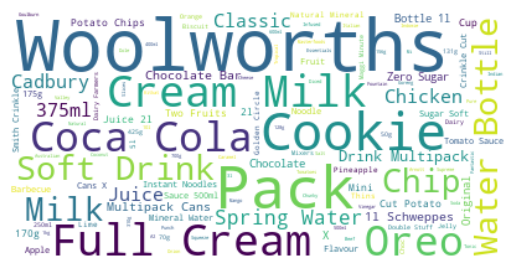

In [54]:
#Word Cloud Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Merge all text data
text = " ".join(description for description in df['description'] if description)

# generated word cloud
wordcloud = WordCloud(background_color="white").generate(text)

# Show word cloud images
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [65]:
# Products and prices
# Modified Cypher query
query = """
MATCH (p:Product)
WHERE p.price IS NOT NULL
RETURN p.name AS ProductName, p.price AS Price
"""

# Executing the query and retrieving data
product_data = []
with driver.session() as session:
    result = session.run(query)
    for record in result:
        product_data.append(record.data())
driver.close()


# Creating DataFrame from the retrieved data
df = pd.DataFrame(product_data)

import plotly.express as px

# Creating a bar chart
fig = px.bar(df, x='ProductName', y='Price', title='Price of Products')

# Displaying the chart
fig.show()





C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\1657285183.py:10: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



In [67]:
query = """
MATCH (p:Product)
RETURN p.name AS ProductName, p.rating AS Rating1, p.Rating AS Rating2, p.Ratings AS Rating3
"""

# Execute the query and get the data
product_data = []
with driver.session() as session:
    result = session.run(query)
    for record in result:
        product_data.append(record.data())

driver.close()

C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\4206007845.py:8: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



In [74]:
from neo4j import GraphDatabase
import pandas as pd
import re
import plotly.express as px



# Modified Cypher Queries
query = """
MATCH (p:Product)
RETURN p.name AS ProductName, p.rating AS Rating1, p.Rating AS Rating2, p.Ratings AS Rating3

"""

# Execute the query and get the data
product_data = []
with driver.session() as session:
    result = session.run(query)
    for record in result:
        product_data.append(record.data())

driver.close()

# Creating a DataFrame
df = pd.DataFrame(product_data)


import pandas as pd
import re

# Data preprocessing functions
def unify_rating(rating):
    if pd.isnull(rating):
        return None
    if '/' in rating:
        # Score format "4.5/5"
        return float(rating.split('/')[0])
    # Adaptation of the "4.2 out of 5" format
    match = re.search(r'\d+(\.\d+)?(?=\s*out\s*of\s*5)', rating)
    if match:
        return float(match.group())
    # If the rating is already in numeric format
    try:
        return float(rating)
    except ValueError:
        return None  # Returns None if the conversion fails

# Sample usage
ratings = [
    "4.5/5", 
    "Average rating of 4.2 out of 5 stars based on 10,000+ reviews",
    "4.7 out of 5",
    "Not Rated"
]

# Use the function and output the result
for r in ratings:
    print(unify_rating(r))





C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\1028075650.py:17: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



4.5
4.2
4.7
None


In [75]:
df['UnifiedRating1'] = df['Rating1'].apply(unify_rating)
df['UnifiedRating2'] = df['Rating2'].apply(unify_rating)
df['UnifiedRating3'] = df['Rating3'].apply(unify_rating)


In [76]:
import plotly.express as px

# Visualisation of each rating
fig1 = px.bar(df, x='ProductName', y='UnifiedRating1', title='Rating 1 of Products')
fig2 = px.bar(df, x='ProductName', y='UnifiedRating2', title='Rating 2 of Products')
fig3 = px.bar(df, x='ProductName', y='UnifiedRating3', title='Rating 3 of Products')

# Show charts
fig1.show()
fig2.show()
fig3.show()


In [79]:
import re
import pandas as pd

def unify_rating(rating):
    if pd.isnull(rating) or not isinstance(rating, str):
        return None
    
    # Extracting ratings from the "4.5/5" format
    if '/' in rating:
        try:
            return float(rating.split('/')[0])
        except ValueError:
            pass

    # Extracting ratings from "4.2 out of 5" or similar formats
    match = re.search(r'(\d+(\.\d+)?)(?=\s*out\s*of\s*5)', rating)
    if match:
        return float(match.group(1))

    # Trying to convert directly to float
    try:
        return float(rating)
    except ValueError:
        return None

# test function
sample_ratings = ['4.5/5', 'Average rating of 4.2 out of 5 stars', '3.7', None, 'Not Rated', '5 out of 5']
for r in sample_ratings:
    print(f"Original: {r}, Unified: {unify_rating(r)}")


Original: 4.5/5, Unified: 4.5
Original: Average rating of 4.2 out of 5 stars, Unified: 4.2
Original: 3.7, Unified: 3.7
Original: None, Unified: None
Original: Not Rated, Unified: None
Original: 5 out of 5, Unified: 5.0


In [82]:
# Assuming df is the DataFrame we extracted from Neo4j
df['UnifiedRating1'] = df['Rating1'].apply(unify_rating)
df['UnifiedRating2'] = df['Rating2'].apply(unify_rating)
df['UnifiedRating3'] = df['Rating3'].apply(unify_rating)



In [85]:
print(df[['Rating1', 'Rating2', 'Rating3']].head())



  Rating1 Rating2 Rating3
0    None    None    None
1    None    None    None
2    None    None    None
3    None    None    None
4    None    None    None


In [89]:
from neo4j import GraphDatabase
import json
import matplotlib.pyplot as plt

def get_nutritional_information(tx, product_name):
    query = (
        "MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe) "
        "WHERE p.name CONTAINS $product_name "
        "RETURN r.nutritionalInformation AS nutrition"
    )
    result = tx.run(query, product_name=product_name)
    return [json.loads(record["nutrition"]) for record in result]

# visualisation function
def visualize_data(data):
    # Assuming that each data item is nutritional information for a recipe
    for nutrition_info in data:
        # Extraction of key indicators
        nutrients = list(nutrition_info.keys())
        values = [float(nutrition_info[n].split(' ')[0]) for n in nutrients if nutrition_info[n] is not None]

        plt.figure(figsize=(10, 6))
        plt.barh(nutrients, values)
        plt.xlabel('Values')
        plt.title('Nutritional Information')
        plt.show()

# Execute queries and visualisations
with driver.session() as session:
    nutritional_data = session.read_transaction(get_nutritional_information, "Cadbury Chocolate Bar")
    visualize_data(nutritional_data)

driver.close()


C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\4064166324.py:30: DeprecationWarning:

read_transaction has been renamed to execute_read



In [90]:
from neo4j import GraphDatabase
import json

def get_nutritional_info(tx):
    # Execution of Cypher queries
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)
    WHERE p.name CONTAINS 'Cadbury' AND p.name CONTAINS 'Chocolate Bar'
    RETURN r.nutritionalInformation AS nutritionalInfo
    """
    result = tx.run(query)
    return [json.loads(record["nutritionalInfo"]) for record in result]

# Connecting to the database and executing queries
with driver.session() as session:
    nutritional_infos = session.read_transaction(get_nutritional_info)

# Next you can process and visualise nutritional_infos
# For example, print out the nutritional information for each product
for info in nutritional_infos:
    print(info)

# Close the database connection
driver.close()


C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\1373339391.py:15: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\1373339391.py:16: DeprecationWarning:

read_transaction has been renamed to execute_read



{'Calcium': '163mg', 'Carbohydrate': '57.90g', 'Cholesterol': '14mg', 'Dietary Fibre': '1.4g', 'Energy kJ': '2230.00kJ', 'Fat Saturated': '18.90g', 'Fat Total': '29.60g', 'Fat Total Quantity Per 100g - ValueWord - NIP': '29.60', 'Monounsaturated': '7.99g', 'Polyunsaturated': '1.02g', 'Potassium': '327mg', 'Protein': '7.60g', 'Sodium': '83.00mg', 'Sugars Quantity Per 100g - Prefix - NIP': None, 'Sugars Quantity Per 100g - SuffixUnits - NIP': 'g', 'Sugars': '56.60g', 'Sugars Quantity Per 100g - ValueWord - NIP': '56.60', 'Trans': '121.58mg'}
{'Calcium': '163mg', 'Carbohydrate': '57.90g', 'Cholesterol': '14mg', 'Dietary Fibre': '1.4g', 'Energy kJ': '2230.00kJ', 'Fat Saturated': '18.90g', 'Fat Total': '29.60g', 'Fat Total Quantity Per 100g - ValueWord - NIP': '29.60', 'Monounsaturated': '7.99g', 'Polyunsaturated': '1.02g', 'Potassium': '327mg', 'Protein': '7.60g', 'Sodium': '83.00mg', 'Sugars Quantity Per 100g - Prefix - NIP': None, 'Sugars Quantity Per 100g - SuffixUnits - NIP': 'g', 'Sug

In [99]:
# Extract useful informations
from neo4j import GraphDatabase
import json

def get_product_info(tx):
    # Execution of Cypher queries
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)
    WHERE p.name CONTAINS 'Cadbury' AND p.name CONTAINS 'Chocolate Bar'
    RETURN p.name AS productName, r.nutritionalInformation AS nutritionalInfo
    """
    result = tx.run(query)
    return [{"name": record["productName"], "info": json.loads(record["nutritionalInfo"])} for record in result]

# Connecting to the database and executing queries
with driver.session() as session:
    product_infos = session.read_transaction(get_product_info)

# Print the name of each product and the corresponding nutritional information.
for product in product_infos:
    print(f"Product Name: {product['name']}")
    print("Nutritional Information:")
    for key, value in product['info'].items():
        print(f"  {key}: {value}")

# Closed database connection
driver.close()





C:\Users\Wesle\AppData\Local\Temp\ipykernel_18052\2440001323.py:16: DeprecationWarning:

read_transaction has been renamed to execute_read



Product Name: Cadbury Dairy Milk Chocolate Bar
Nutritional Information:
  Calcium: 163mg
  Carbohydrate: 57.90g
  Cholesterol: 14mg
  Dietary Fibre: 1.4g
  Energy kJ: 2230.00kJ
  Fat Saturated: 18.90g
  Fat Total: 29.60g
  Fat Total Quantity Per 100g - ValueWord - NIP: 29.60
  Monounsaturated: 7.99g
  Polyunsaturated: 1.02g
  Potassium: 327mg
  Protein: 7.60g
  Sodium: 83.00mg
  Sugars Quantity Per 100g - Prefix - NIP: None
  Sugars Quantity Per 100g - SuffixUnits - NIP: g
  Sugars: 56.60g
  Sugars Quantity Per 100g - ValueWord - NIP: 56.60
  Trans: 121.58mg
Product Name: Cadbury Twirl Chocolate Bar
Nutritional Information:
  Calcium: 163mg
  Carbohydrate: 57.90g
  Cholesterol: 14mg
  Dietary Fibre: 1.4g
  Energy kJ: 2230.00kJ
  Fat Saturated: 18.90g
  Fat Total: 29.60g
  Fat Total Quantity Per 100g - ValueWord - NIP: 29.60
  Monounsaturated: 7.99g
  Polyunsaturated: 1.02g
  Potassium: 327mg
  Protein: 7.60g
  Sodium: 83.00mg
  Sugars Quantity Per 100g - Prefix - NIP: None
  Sugars Qua

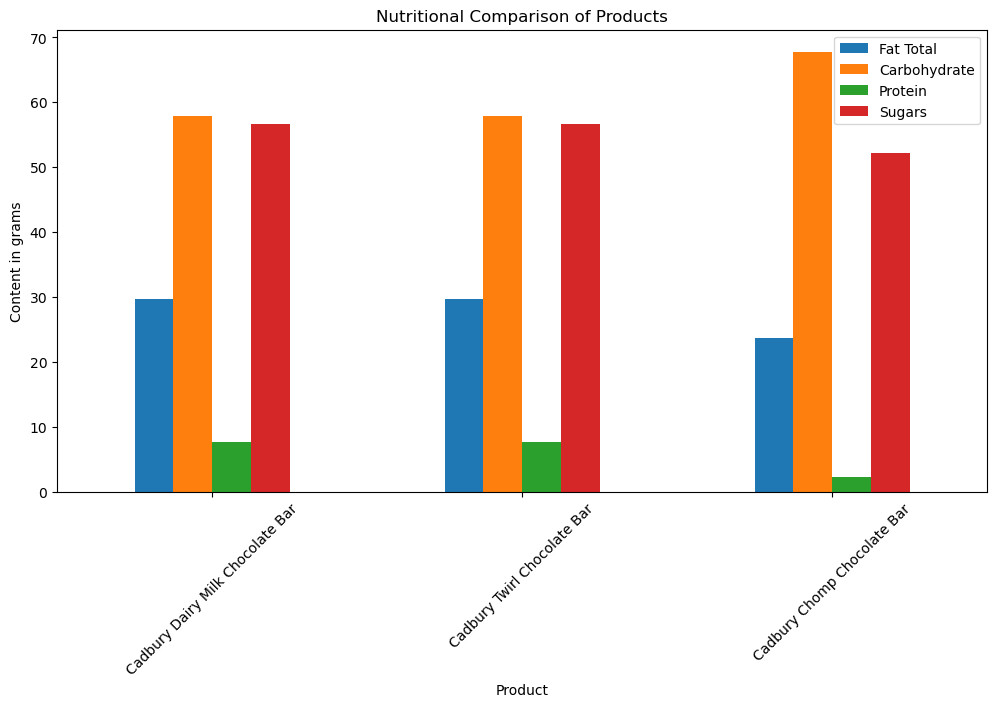

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming product_infos is the data we get from the database

# Data preprocessing
nutrients = ["Calcium", "Carbohydrate", "Cholesterol", "Dietary Fibre", "Energy kJ", "Fat Saturated",
             "Fat Total", "Monounsaturated", "Polyunsaturated", "Potassium", "Protein", "Sodium",
             "Sugars", "Trans"]
data = {"Product": [product["name"] for product in product_infos]}

for nutrient in nutrients:
    data[nutrient] = [float(product["info"].get(nutrient, "0g").rstrip("g").rstrip("mg").rstrip("kJ")) for product in product_infos]

df = pd.DataFrame(data)

# visualisation
df.set_index("Product", inplace=True)

# Due to the large number of ingredients, only some of the main ingredients are shown.
selected_nutrients = ["Fat Total", "Carbohydrate", "Protein", "Sugars"]
df[selected_nutrients].plot(kind="bar", figsize=(12, 6))

plt.title("Nutritional Comparison of Products")
plt.ylabel("Content in grams")
plt.xlabel("Product")
plt.xticks(rotation=45)
plt.show()


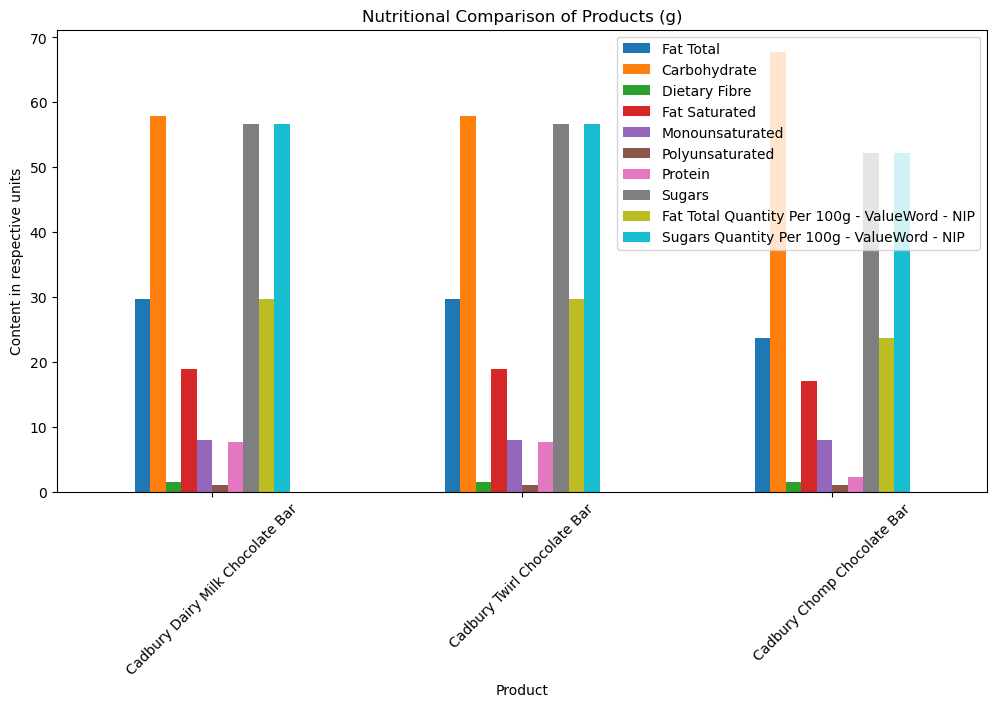

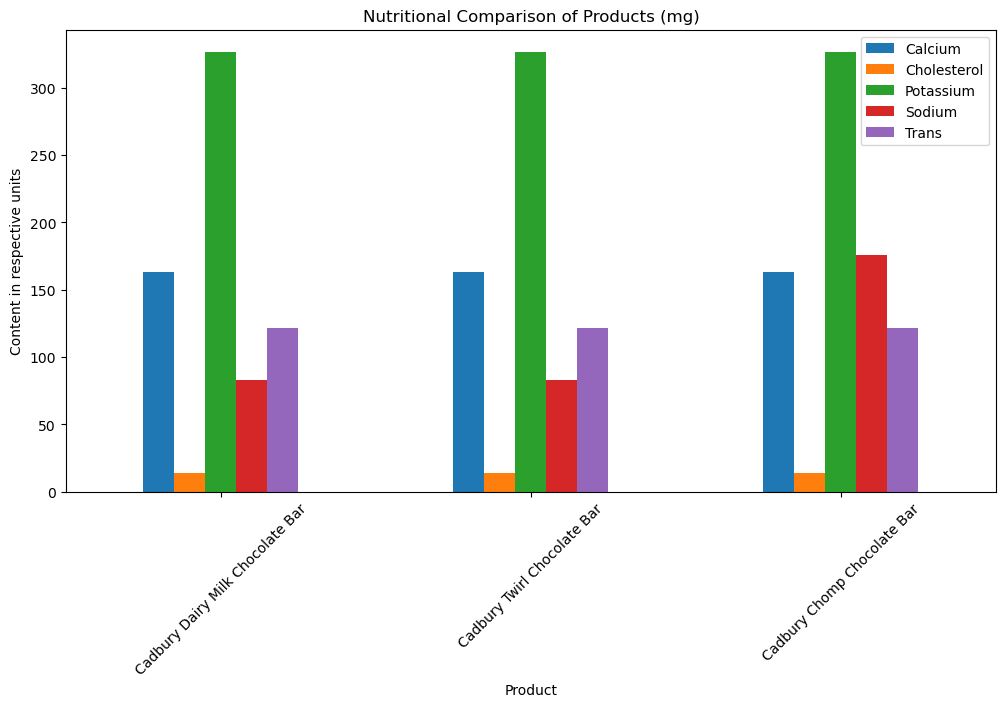

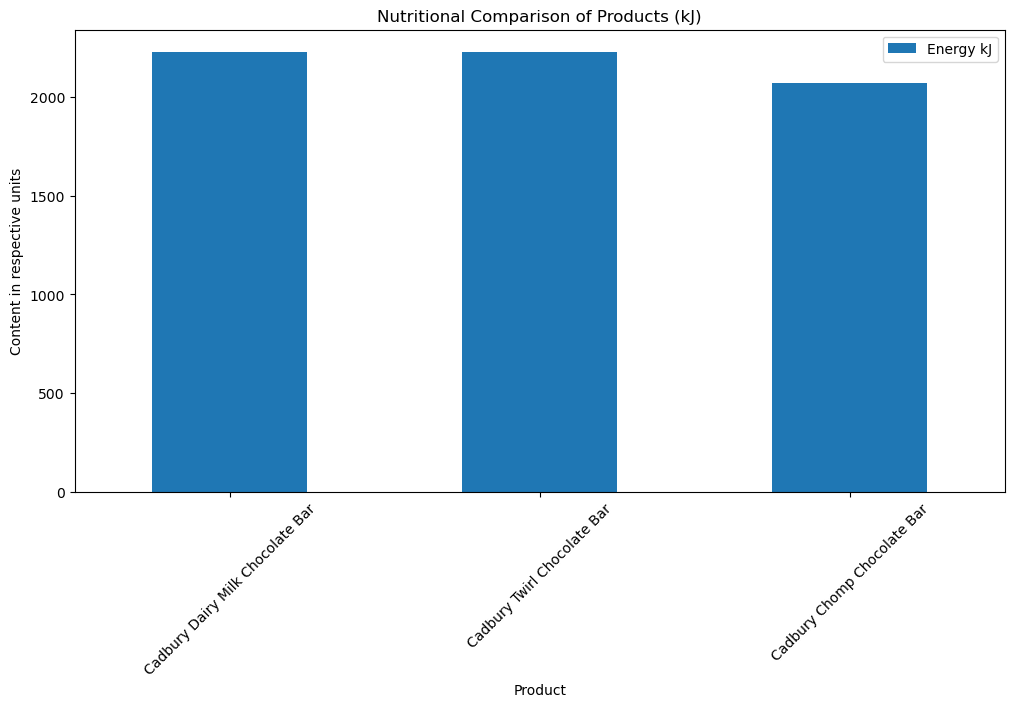

In [108]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming product_infos is fetching data from the database

# Extract nutrients in g, mg and kJ
nutrients_g = ["Fat Total", "Carbohydrate", "Dietary Fibre", "Fat Saturated", "Monounsaturated", 
               "Polyunsaturated", "Protein", "Sugars", "Fat Total Quantity Per 100g - ValueWord - NIP", 
               "Sugars Quantity Per 100g - ValueWord - NIP"]
nutrients_mg = ["Calcium", "Cholesterol", "Potassium", "Sodium", "Trans"]
nutrients_kJ = ["Energy kJ"]

# Data pre-processing
def extract_nutrient_values(product_infos, nutrient_list):
    data = {"Product": [product["name"] for product in product_infos]}
    for nutrient in nutrient_list:
        data[nutrient] = [float(product["info"].get(nutrient, "0g").rstrip("g").rstrip("mg").rstrip("kJ")) for product in product_infos]
    return pd.DataFrame(data)

df_g = extract_nutrient_values(product_infos, nutrients_g)
df_mg = extract_nutrient_values(product_infos, nutrients_mg)
df_kJ = extract_nutrient_values(product_infos, nutrients_kJ)

# Create bar charts for visualisation
def plot_nutrients(df, title):
    df.set_index("Product", inplace=True)
    df.plot(kind="bar", figsize=(12, 6))
    plt.title(title)
    plt.ylabel("Content in respective units")
    plt.xlabel("Product")
    plt.xticks(rotation=45)
    plt.show()

plot_nutrients(df_g, "Nutritional Comparison of Products (g)")
plot_nutrients(df_mg, "Nutritional Comparison of Products (mg)")
plot_nutrients(df_kJ, "Nutritional Comparison of Products (kJ)")


In [3]:
from neo4j import GraphDatabase
import json
import pandas as pd
import matplotlib.pyplot as plt


def get_product_info(tx):
    # Execution of Cypher queries
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)
    WHERE p.name IN ['Coca - Cola Zero Sugar Soft Drink Multipack Cans', 'Coca - Cola Classic Soft Drink Multipack Cans', 'Coca - Cola Vanilla  Soft Drink Multipack Cans']
    RETURN p.name AS productName, r.nutritionalInformation AS nutritionalInfo
    """
    result = tx.run(query)
    return [{"name": record["productName"], "info": json.loads(record["nutritionalInfo"])} for record in result]

# Connecting to the database and executing queries
with driver.session() as session:
    product_infos = session.read_transaction(get_product_info)

# Print the name of each product and the corresponding nutritional information
for product in product_infos:
    print(f"Product Name: {product['name']}")
    print("Nutritional Information:")
    for key, value in product['info'].items():
        print(f"  {key}: {value}")

# Close the database connection
driver.close()





C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\959279599.py:19: DeprecationWarning: read_transaction has been renamed to execute_read
  product_infos = session.read_transaction(get_product_info)


Product Name: Coca - Cola Vanilla  Soft Drink Multipack Cans
Nutritional Information:
  Carbohydrate: 11.00g
  Energy kJ: 185.00kJ
  Fat Saturated: 0.00g
  Fat Total: 0.00g
  Fat Total Quantity Per 100g - ValueWord - NIP: 0.00
  Protein: 0.00g
  Sodium: 10.00mg
  Sugars Quantity Per 100g - Prefix - NIP: None
  Sugars Quantity Per 100g - SuffixUnits - NIP: g
  Sugars: 10.90g
  Sugars Quantity Per 100g - ValueWord - NIP: 10.90
Product Name: Coca - Cola Zero Sugar Soft Drink Multipack Cans
Nutritional Information:
  Carbohydrate: 0.03g
  Dietary Fibre: 0.00g
  Energy kJ: 1.20kJ
  Fat Saturated: 0.00g
  Fat Total: 0.00g
  Fat Total Quantity Per 100g - ValueWord - NIP: 0.00
  Protein: 0.02g
  Sodium: 4.10mg
  Sugars Quantity Per 100g - Prefix - NIP: None
  Sugars Quantity Per 100g - SuffixUnits - NIP: g
  Sugars: 0.00g
  Sugars Quantity Per 100g - ValueWord - NIP: 0.00
Product Name: Coca - Cola Zero Sugar Soft Drink Multipack Cans
Nutritional Information:
  Carbohydrate: 0.03g
  Dietary Fib

In [4]:
print(product_infos)

[{'name': 'Coca - Cola Vanilla  Soft Drink Multipack Cans', 'info': {'Carbohydrate': '11.00g', 'Energy kJ': '185.00kJ', 'Fat Saturated': '0.00g', 'Fat Total': '0.00g', 'Fat Total Quantity Per 100g - ValueWord - NIP': '0.00', 'Protein': '0.00g', 'Sodium': '10.00mg', 'Sugars Quantity Per 100g - Prefix - NIP': None, 'Sugars Quantity Per 100g - SuffixUnits - NIP': 'g', 'Sugars': '10.90g', 'Sugars Quantity Per 100g - ValueWord - NIP': '10.90'}}, {'name': 'Coca - Cola Zero Sugar Soft Drink Multipack Cans', 'info': {'Carbohydrate': '0.03g', 'Dietary Fibre': '0.00g', 'Energy kJ': '1.20kJ', 'Fat Saturated': '0.00g', 'Fat Total': '0.00g', 'Fat Total Quantity Per 100g - ValueWord - NIP': '0.00', 'Protein': '0.02g', 'Sodium': '4.10mg', 'Sugars Quantity Per 100g - Prefix - NIP': None, 'Sugars Quantity Per 100g - SuffixUnits - NIP': 'g', 'Sugars': '0.00g', 'Sugars Quantity Per 100g - ValueWord - NIP': '0.00'}}, {'name': 'Coca - Cola Zero Sugar Soft Drink Multipack Cans', 'info': {'Carbohydrate': '0.

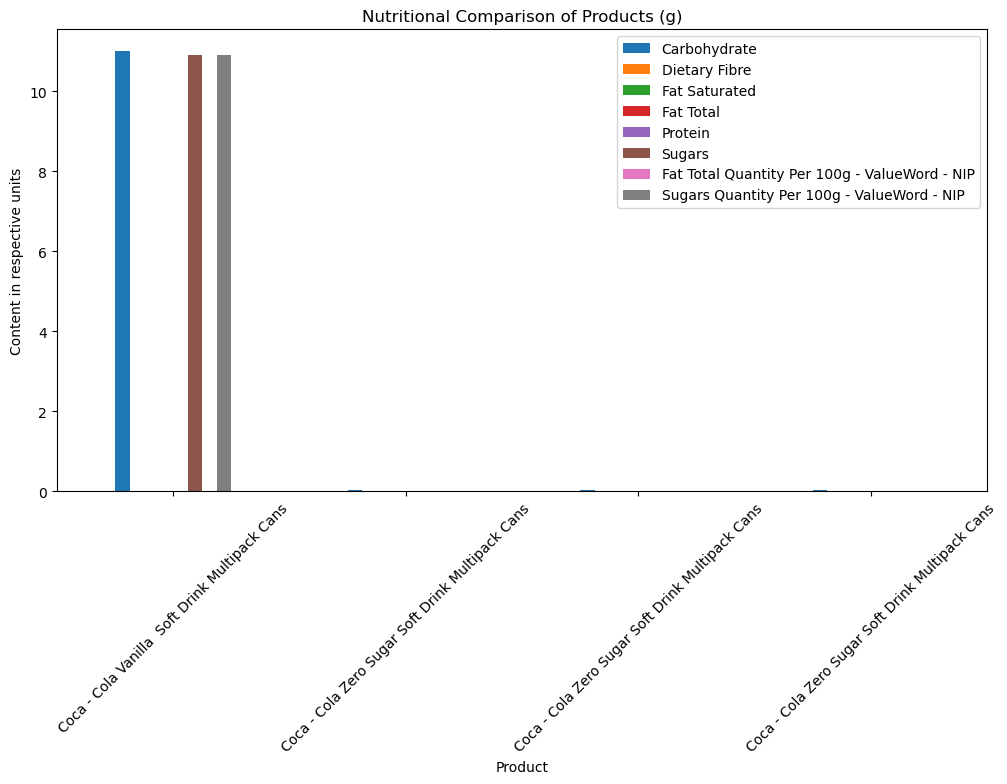

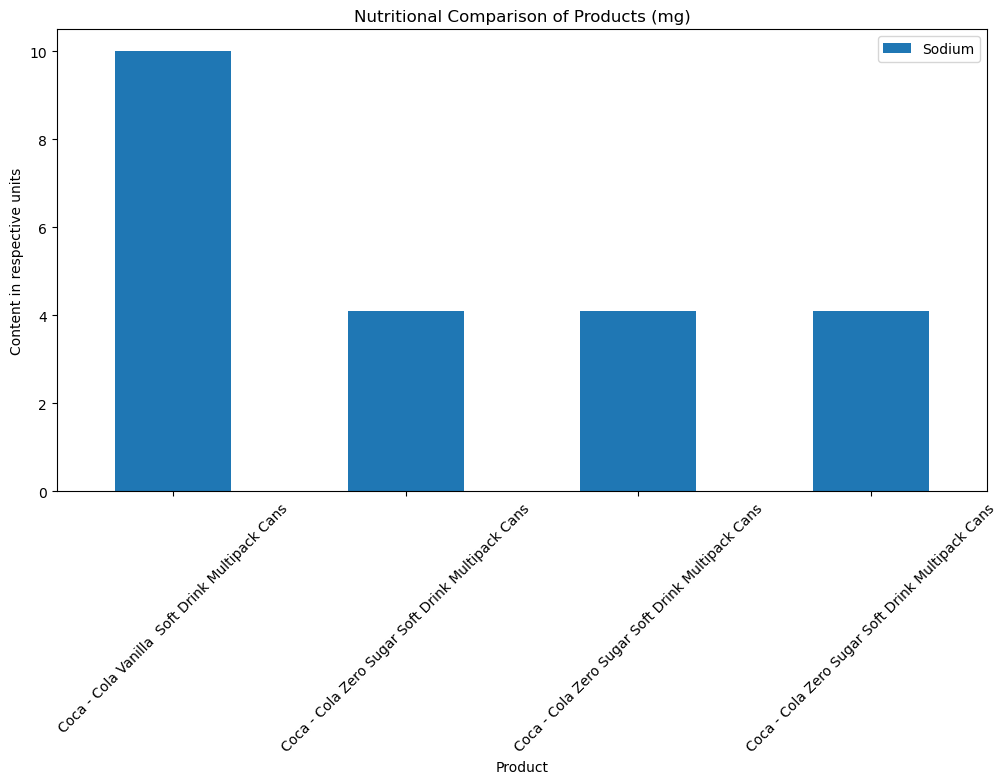

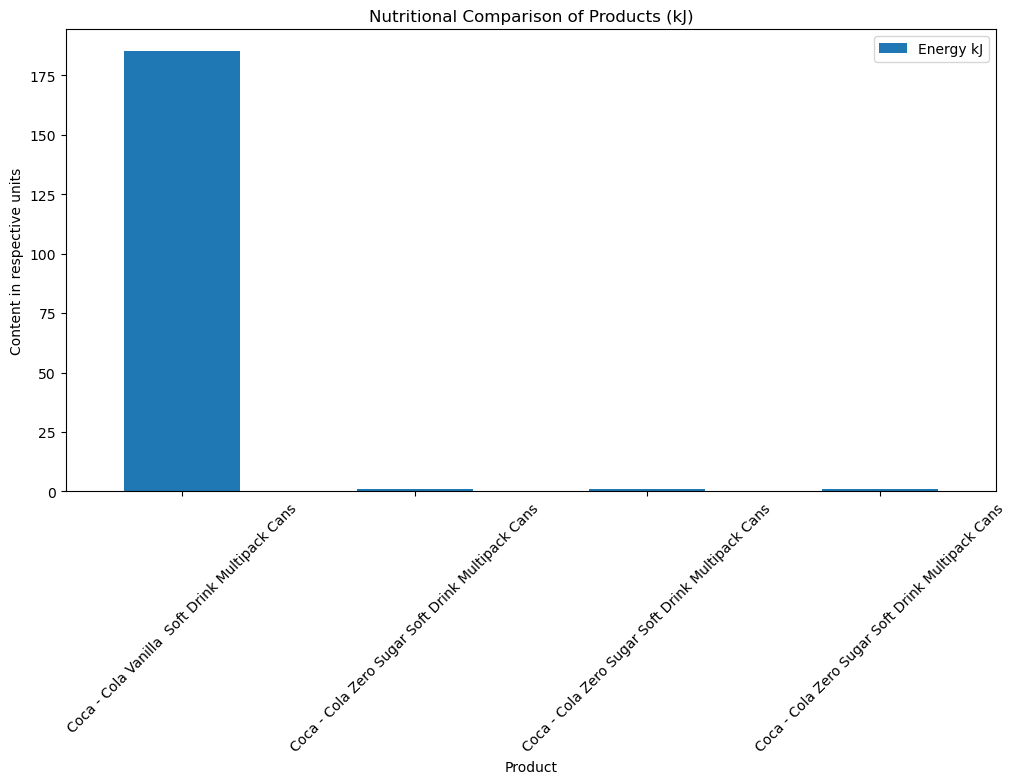

In [5]:
import pandas as pd
import matplotlib.pyplot as plt


# Assuming product_infos is fetching data from the database

# Extract nutrients in g, mg and kJ
nutrients_g = ["Carbohydrate", "Dietary Fibre", "Fat Saturated", "Fat Total", 
               "Protein", "Sugars", "Fat Total Quantity Per 100g - ValueWord - NIP", 
               "Sugars Quantity Per 100g - ValueWord - NIP"]
nutrients_mg = ["Sodium"]
nutrients_kJ = ["Energy kJ"]

# Data pre-processing
def extract_nutrient_values(product_infos, nutrient_list):
    data = {"Product": [product["name"] for product in product_infos]}
    for nutrient in nutrient_list:
        data[nutrient] = [float(product["info"].get(nutrient, "0g").rstrip("g").rstrip("mg").rstrip("kJ")) for product in product_infos]
    return pd.DataFrame(data)

df_g = extract_nutrient_values(product_infos, nutrients_g)
df_mg = extract_nutrient_values(product_infos, nutrients_mg)
df_kJ = extract_nutrient_values(product_infos, nutrients_kJ)

# Create bar charts for visualisation
def plot_nutrients(df, title):
    df.set_index("Product", inplace=True)
    df.plot(kind="bar", figsize=(12, 6))
    plt.title(title)
    plt.ylabel("Content in respective units")
    plt.xlabel("Product")
    plt.xticks(rotation=45)
    plt.show()

plot_nutrients(df_g, "Nutritional Comparison of Products (g)")
plot_nutrients(df_mg, "Nutritional Comparison of Products (mg)")
plot_nutrients(df_kJ, "Nutritional Comparison of Products (kJ)")

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\878422718.py:14: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\878422718.py:15: DeprecationWarning:

read_transaction has been renamed to execute_read



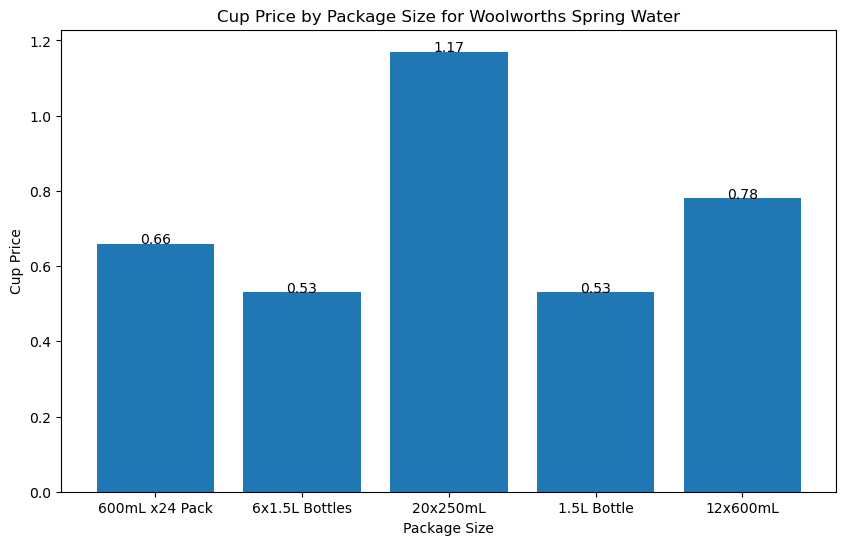

In [36]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt

def get_product_data(tx, product_name):
    query = """
        MATCH (p:Product) 
        WHERE p.name CONTAINS 'Woolworths Spring Water'
        RETURN p.packageSize AS packageSize, p.cupPrice AS cupPrice
    """
    result = tx.run(query)
    return [(record["packageSize"], record["cupPrice"]) for record in result]
  
# Getting data
with driver.session() as session:
    data = session.read_transaction(get_product_data, "Woolworths Spring Water")


driver.close()

# Data visualisation


plt.figure(figsize=(10,6))  # Resize the image for a better display
plt.bar(package_sizes, cup_prices)
for i in range(len(package_sizes)):
    plt.text(package_sizes[i], cup_prices[i], str(cup_prices[i]), ha='center')

plt.xlabel('Package Size')
plt.ylabel('Cup Price')
plt.title('Cup Price by Package Size for Woolworths Spring Water')
plt.show()


In [54]:
import plotly.express as px
from neo4j import GraphDatabase
import re

def extract_sugars(nutritional_info):
    # Improved regular expression to match different sugar content formats
    match = re.search(r'"Sugars": "(Approx\.)?([0-9.]+)g"', nutritional_info)
    return float(match.group(2)) if match else None

def get_data(tx):
    query = (
        "MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe) "
        "WHERE p.cupPrice IS NOT NULL AND r.nutritionalInformation CONTAINS 'Sugars' "
        "RETURN p.name AS productName, p.cupPrice AS cupPrice, r.nutritionalInformation AS nutritionalInfo"
    )
    result = tx.run(query)
    return [
        {
            "productName": record["productName"], 
            "cupPrice": record["cupPrice"], 
            "sugars": extract_sugars(record["nutritionalInfo"])
        }
        for record in result 
        if extract_sugars(record["nutritionalInfo"]) is not None
    ]

# Getting data
with driver.session() as session:
    data = session.read_transaction(get_data)


driver.close()

# Data visualisation
# Data visualisation
fig = px.scatter(
    data, 
    x=[d['sugars'] for d in data], 
    y=[d['cupPrice'] for d in data], 
    hover_data=['productName'], 
    labels={'x': 'Sugars (g)', 'y': 'Cup Price'},
    title='Cup Price vs Sugars Content'
)
fig.show()


C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\3561919196.py:28: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\3561919196.py:29: DeprecationWarning:

read_transaction has been renamed to execute_read



In [55]:
from scipy.stats import pearsonr
 
# Extract sugars and cupPrice data
sugars = [d['sugars'] for d in data]
cup_prices = [d['cupPrice'] for d in data]

# Calculate Pearson correlation coefficient and p-value
corr_coefficient, p_value = pearsonr(sugars, cup_prices)

# Displaying results in charts and graphs
fig.update_layout(
    title=f'Cup Price vs Sugars Content (Correlation: {corr_coefficient:.2f}, P-value: {p_value:.2f})'
)

fig.show()


In [56]:
import plotly.express as px
from neo4j import GraphDatabase
import re

def extract_protein(nutritional_info):
    # Regular expression to find protein content, matches many possible formats, including "<1.00g"
    matches = re.findall(r'"Protein":\s*"(<)?(Approx\.)?([0-9.]+)g"', nutritional_info)
    # Iterates over all matches and returns the first valid value
    for match in matches:
        if match[2]:  # The third grouping that matches is the value of protein content
            value = float(match[2])
            # The presence of a "<" sign indicates that the actual value may be less than this value.
            if match[0]:
                value = value - 0.01  # Decrease by one small unit to indicate that it is an upper limit
            return value
    return None

def get_data(tx):
    query = (
        "MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe) "
        "WHERE p.cupPrice IS NOT NULL AND r.nutritionalInformation CONTAINS 'Protein' "
        "RETURN p.name AS productName, p.cupPrice AS cupPrice, r.nutritionalInformation AS nutritionalInfo"
    )
    result = tx.run(query)
    return [
        {
            "productName": record["productName"], 
            "cupPrice": record["cupPrice"], 
            "protein": extract_protein(record["nutritionalInfo"])
        }
        for record in result 
        if extract_protein(record["nutritionalInfo"]) is not None
    ]

# Getting data
with driver.session() as session:
    data = session.read_transaction(get_data)


driver.close()


# Data visualisation
fig = px.scatter(
    filtered_data, 
    x=[d['protein'] for d in filtered_data], 
    y=[d['cupPrice'] for d in filtered_data], 
    hover_data=['productName'], 
    labels={'x': 'Protein (g)', 'y': 'Cup Price'},
    title='Cup Price vs Protein Content'
)
fig.show()


C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\1761765810.py:36: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\1761765810.py:37: DeprecationWarning:

read_transaction has been renamed to execute_read



In [57]:
from scipy.stats import pearsonr

# Extracting protein and cupPrice data
protein = [d['protein'] for d in data]
cup_prices = [d['cupPrice'] for d in data]

# Calculate Pearson correlation coefficient and p-value
corr_coefficient, p_value = pearsonr(protein, cup_prices)

# Displaying results in charts and graphs
fig.update_layout(
    title=f'Cup Price vs Protein Content (Correlation: {corr_coefficient:.2f}, P-value: {p_value:.2f})'
)

fig.show()


C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\1656174653.py:11: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\1656174653.py:12: DeprecationWarning:

read_transaction has been renamed to execute_read



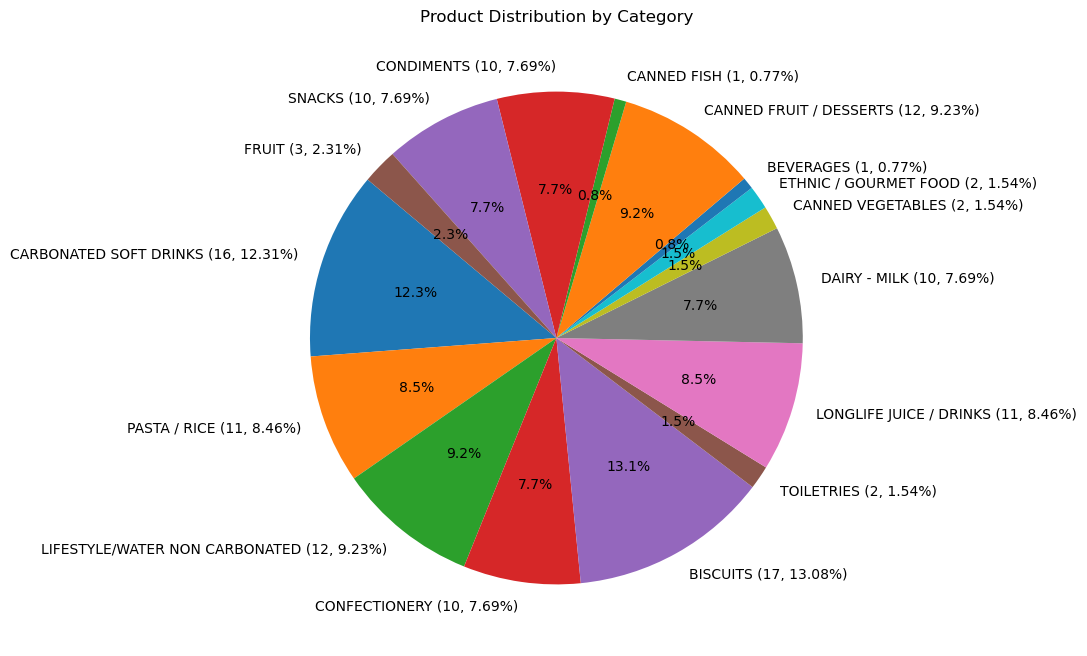

In [63]:
import matplotlib.pyplot as plt
from neo4j import GraphDatabase


def get_category_data(tx):
    query = "MATCH (p:Product)-[:STOCKED_IN]->(c:Category) RETURN c.name AS categoryName, COUNT(p) AS productCount"
    result = tx.run(query)
    return [(record["categoryName"], record["productCount"]) for record in result]

# Getting data
with driver.session() as session:
    data = session.read_transaction(get_category_data)

driver.close()

# Processing of data for plotting
categories, product_counts = zip(*data)
total = sum(product_counts)
percentages = [count / total * 100 for count in product_counts]

# Data Visualisation - Creating Pie Charts
plt.figure(figsize=(10, 8))
plt.pie(percentages, labels=[f'{cat} ({count}, {percent:.2f}%)' for cat, count, percent in zip(categories, product_counts, percentages)], autopct='%1.1f%%', startangle=140)
plt.title('Product Distribution by Category')
plt.show()


In [53]:
import plotly.graph_objects as go

# Using the same data
categories, product_counts = zip(*data)
total = sum(product_counts)
percentages = [count / total * 100 for count in product_counts]
labels = [f'{cat} ({count}, {percent:.2f}%)' for cat, count, percent in zip(categories, product_counts, percentages)]

# Creating Pie Charts
fig = go.Figure(data=[go.Pie(labels=labels, values=percentages, pull=[0.05]*len(categories))])

# Updating the layout
fig.update_layout(
    title='Product Distribution by Category',
    title_x=0.5,
)

# Show charts
fig.show()


In [65]:
def get_sampled_nutritional_data(tx):
    query = (
        "MATCH (p:Product)-[:STOCKED_IN]->(c:Category), (p)-[:HAS_RECIPE]->(r:Recipe) "
        "WITH c.name AS categoryName, collect({productName: p.name, nutritionalInfo: r.nutritionalInformation}) AS products "
        "RETURN categoryName, products[toInteger(floor(rand() * size(products)))].nutritionalInfo AS sampledNutritionalInfo"
    )
    result = tx.run(query)
    return [(record["categoryName"], record["sampledNutritionalInfo"]) for record in result]

# Getting data
with driver.session() as session:
    sampled_data = session.read_transaction(get_sampled_nutritional_data)



C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\2805490084.py:11: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\2805490084.py:12: DeprecationWarning:

read_transaction has been renamed to execute_read



In [67]:
import json
import re

def parse_nutritional_info(nutritional_info_str):
    # Check if nutritional_info_str is a string
    if not isinstance(nutritional_info_str, str):
        raise ValueError("Nutritional information is not a string.")

    # Converting strings to dictionaries
    try:
        nutritional_info = json.loads(nutritional_info_str)
    except json.JSONDecodeError:
        raise ValueError("Error decoding JSON from nutritional information.")

    parsed_data = {}
    for key, value in nutritional_info.items():
        # Checks if each value is a string
        if isinstance(value, str):
            match = re.match(r"Approx\.?([0-9.]+)(g|mg|kJ)", value)
            if match:
                parsed_data[key] = {"value": float(match.group(1)), "unit": match.group(2)}
    return parsed_data

parsed_sampled_data = {category: parse_nutritional_info(info) for category, info in sampled_data}



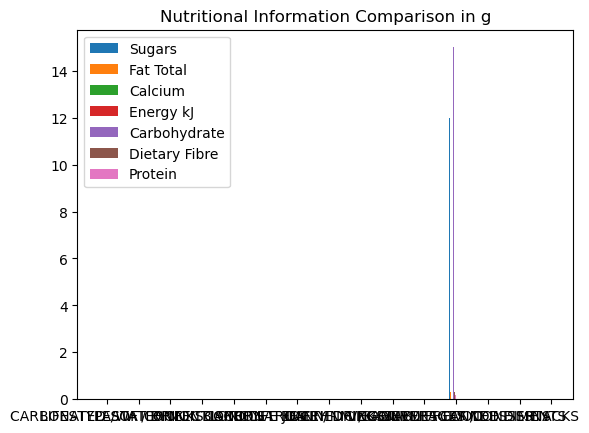

In [69]:
def plot_nutritional_data(data, unit):
    categories = data.keys()
    all_nutrients = set()
    for nutrients in data.values():
        all_nutrients.update(nutrients.keys())

    nutritional_values = {nutrient: [0] * len(categories) for nutrient in all_nutrients}

    for i, (category, nutrients) in enumerate(data.items()):
        for nutrient, info in nutrients.items():
            if info["unit"] == unit:
                nutritional_values[nutrient][i] = info["value"]

    fig, ax = plt.subplots()
    width = 0.2  # Width of columns
    n = len(all_nutrients)  # Total number of nutrients

    for i, (nutrient, values) in enumerate(nutritional_values.items()):
        ax.bar([x + i * width / n for x in range(len(categories))], values, width=width/n, label=nutrient)

    ax.set_xticks([x + width for x in range(len(categories))])
    ax.set_xticklabels(categories)
    ax.legend()

    plt.title(f'Nutritional Information Comparison in {unit}')
    plt.show()

# Plotting nutritional information in g
plot_nutritional_data(parsed_sampled_data, 'g')




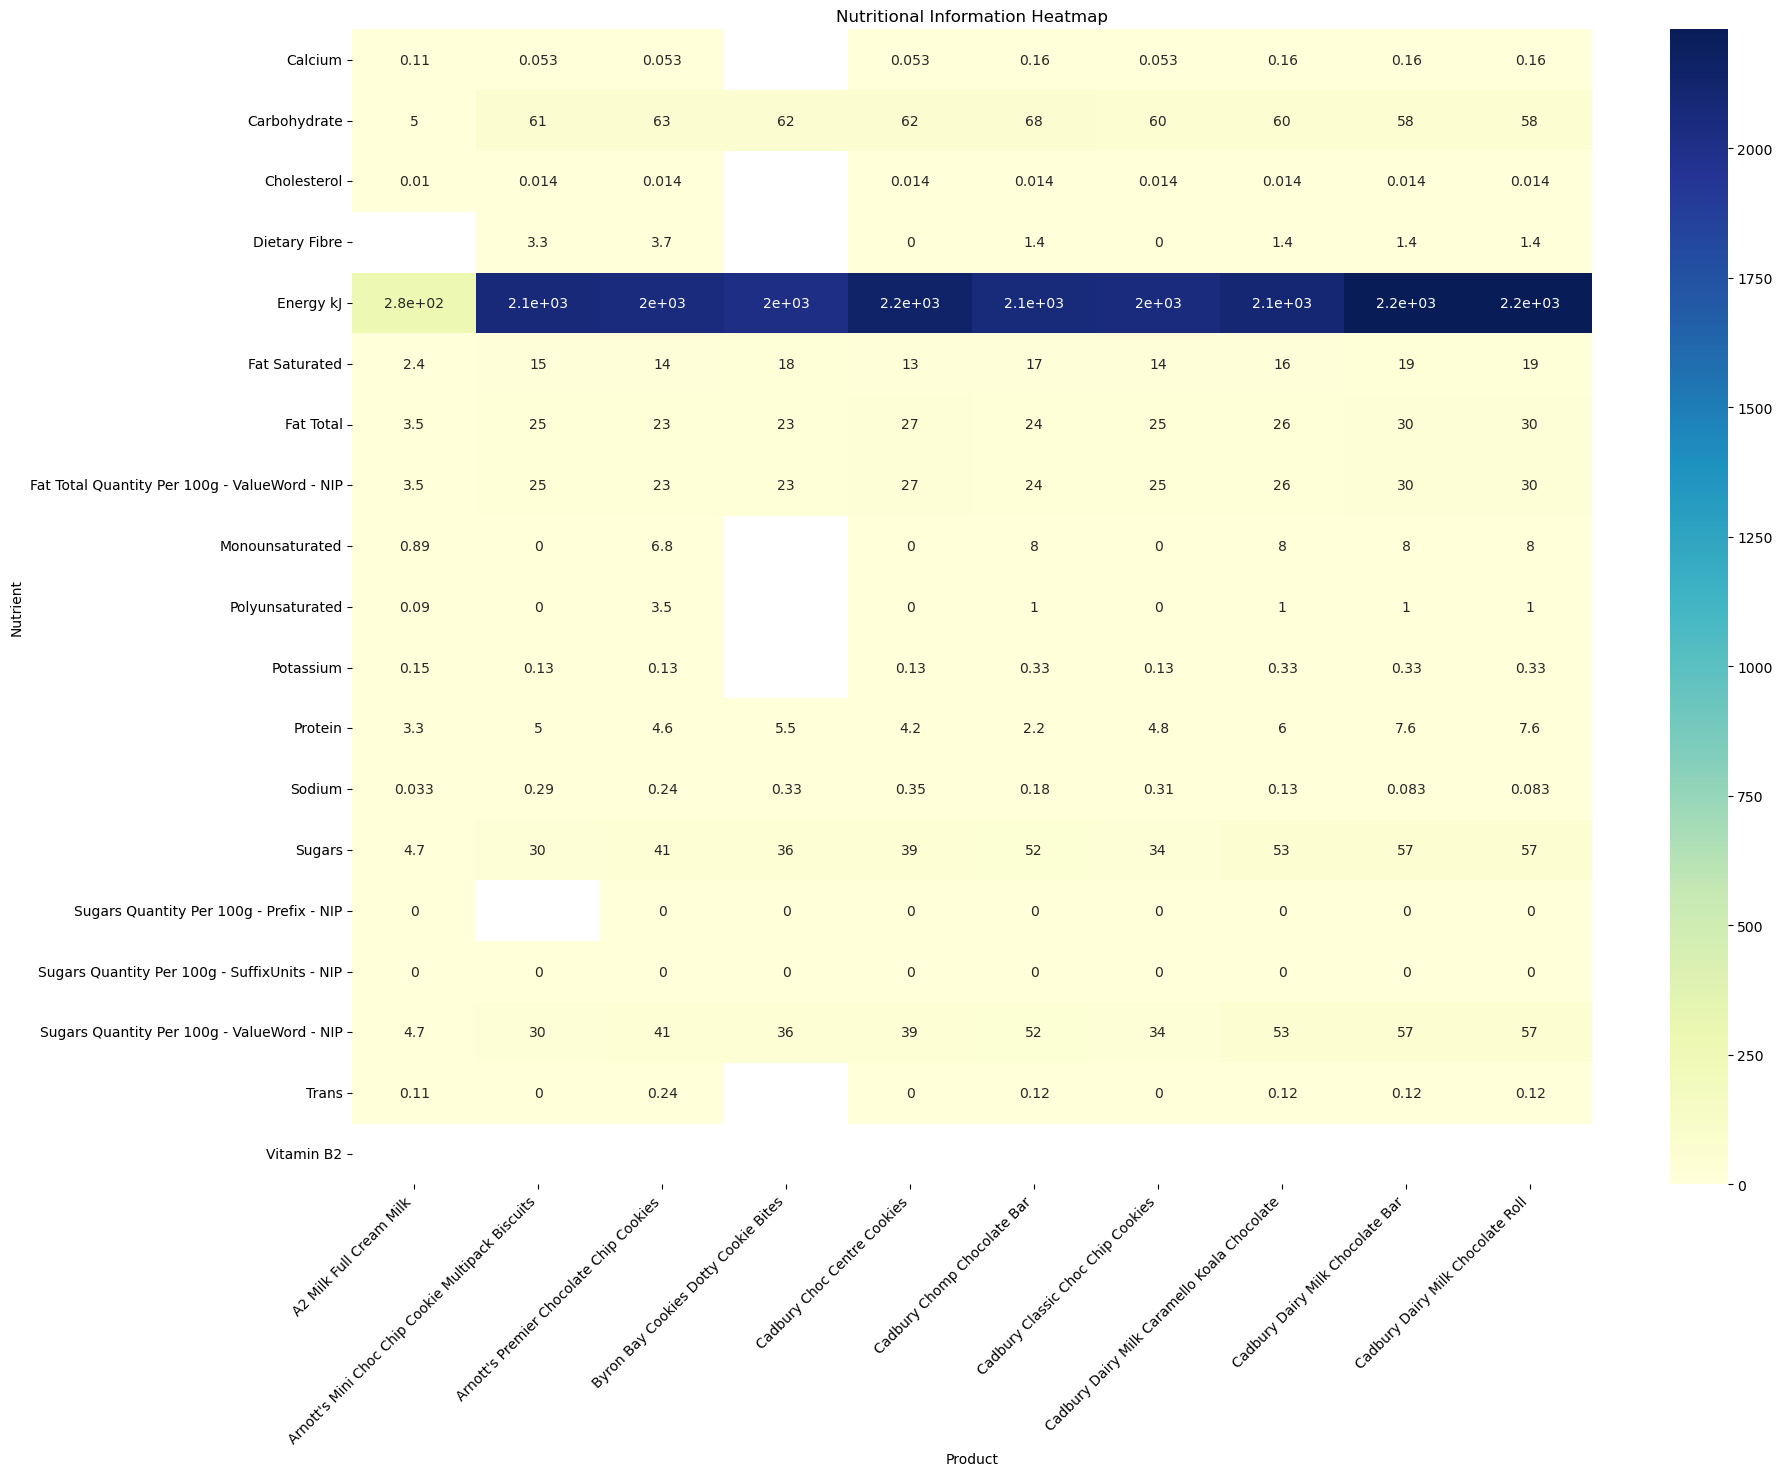

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


# Increase image size
plt.figure(figsize=(20, 15))

# Take only the top 10 products for each nutrient
top_products = pivot_table.columns[:10]
filtered_pivot = pivot_table.loc[:, top_products]

# Creating heat maps
sns.heatmap(filtered_pivot, annot=True, cmap="YlGnBu")

# Add title and axis labels
plt.title('Nutritional Information Heatmap')
plt.xlabel('Product')
plt.ylabel('Nutrient')

# To prevent label overlap, rotary axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Showing graph
plt.show()


In [142]:
import pandas as pd
import json
import re
from neo4j import GraphDatabase
import plotly.graph_objects as go
import plotly.express as px

def get_nutritional_data(tx):
    # Run a Cypher query
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)
    WITH p, r, rand() AS random
    ORDER BY random
    LIMIT 10
    RETURN p.name AS productName, r.nutritionalInformation AS nutritionalInfo
    """
    result = tx.run(query)
    # Extract product name and nutritional information
    return [(record["productName"], record["nutritionalInfo"]) for record in result]

# Getting data from the database
with driver.session() as session:
    nutritional_data = session.read_transaction(get_nutritional_data)

driver.close()


def parse_nutrition_info(nutrition_str):
    try:
        # Remove the prefix "Approx." and the less-than sign "<", which may appear before a value.
        nutrition_str = nutrition_str.replace('Approx.', '').replace('<', '')
        # Loading strings as JSON objects
        nutrition_data = json.loads(nutrition_str)
    except json.JSONDecodeError:
        # Returns an empty dictionary if the string is not in JSON format
        return {}
    #  Parsing values and units using regular expressions
    parsed_nutrients = {}
    for nutrient, value in nutrition_data.items():
        if isinstance(value, str):  
            match = re.match(r"([0-9.]+)(g|mg|kJ)", value)
            if match:
                # Storing nutritional information and its units
                parsed_nutrients[nutrient + ' (' + match.group(2) + ')'] = float(match.group(1))
    return parsed_nutrients


data = []
for product_name, nutritional_info in nutritional_data:
    parsed_data = {'Product': product_name}
    parsed_data.update(parse_nutrition_info(nutritional_info))
    data.append(parsed_data)


# Creating DataFrame
df = pd.DataFrame(data)


def plot_bar_chart_plotly(df, unit):
    #  screening unit
    unit_columns = [col for col in df.columns if col.endswith(f'({unit})')]
    df_unit = df.set_index('Product')[unit_columns]

    # Plotly Plotting
    fig = go.Figure()
    for nutrient in df_unit.columns:
        fig.add_trace(go.Bar(
            x=df_unit.index,
            y=df_unit[nutrient],
            name=nutrient
        ))
    # Updated Chart Layout
    fig.update_layout(
        title=f'Nutritional content in {unit}',
        xaxis_title='Product',
        yaxis_title=f'Amount ({unit})',
        legend_title='Nutrient'
    )


    # Showing graph
    fig.show()

# Plotting a bar graph for each unit
for unit in ['g', 'mg', 'kJ']:
    plot_bar_chart_plotly(df, unit)


C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\4082599151.py:22: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\4082599151.py:23: DeprecationWarning:

read_transaction has been renamed to execute_read



In [103]:
import plotly.express as px
import pandas as pd
from neo4j import GraphDatabase


def get_data(tx):
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe), (p)-[:HAS_RATING]->(h:HealthStarRating)
    RETURN p.name AS productName, size(split(r.ingredients_orig, ',')) AS ingredientCount, h.rating AS healthStarRating
    """
    result = tx.run(query)
    return [(record["productName"], record["ingredientCount"], record["healthStarRating"]) for record in result]

# Fetch the data
with driver.session() as session:
    data = session.read_transaction(get_data)

# Close the database connection
driver.close()

# Convert the data to a DataFrame
df = pd.DataFrame(data, columns=['Product', 'IngredientCount', 'HealthStarRating'])


# Create the scatter plot with plotly 

fig = px.scatter(df, x='IngredientCount', y='HealthStarRating', hover_data=['Product'],
                 title='Health Star Rating vs Ingredient Count',
                 labels={'HealthStarRating': 'Health Star Rating', 'IngredientCount': 'Ingredient Count'})

# Explicitly set the y-axis type to 'category' and define the category order
fig.update_yaxes(type='category', categoryorder='category ascending')

fig.show()

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\4198704517.py:15: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\4198704517.py:16: DeprecationWarning:

read_transaction has been renamed to execute_read



In [100]:
from scipy.stats import pearsonr


# Calculate the Pearson correlation coefficient and the p-value
correlation, p_value = pearsonr(df['HealthStarRating'], df['IngredientCount'])

print("Correlation coefficient:", correlation)
print("P-value:", p_value)


Correlation coefficient: -0.4328082487588446
P-value: 0.00018250675840634034


In [146]:
import plotly.express as px
import pandas as pd
from neo4j import GraphDatabase

def get_data(tx):
    query = """
    MATCH (p:Product)-[:HAS_RECIPE]->(r:Recipe)
OPTIONAL MATCH (r)-[:HAS_MANUFACTURING_PROCESS]->(m:ManufacturingProcess)
WITH p, r, 
    CASE 
        WHEN COUNT(m) > 0 THEN COUNT(m)
        ELSE SIZE(SPLIT(HEAD(COLLECT(m.allSteps)), ','))
    END AS stepCount
RETURN p.name AS productName, p.cupPrice AS cupPrice, stepCount


    """
    result = tx.run(query)
    return [(record["productName"], record["cupPrice"], record["stepCount"]) for record in result]

#  Getting data
with driver.session() as session:
    data = session.read_transaction(get_data)

# Close the database connection
driver.close()

# Convert data to DataFrame
df = pd.DataFrame(data, columns=['Product', 'CupPrice', 'StepCount'])

# Creating Scatterplots with Plotly
fig = px.scatter(df, x='StepCount', y='CupPrice', hover_name='Product',
                 title='Cup Price vs Manufacturing Process Step Count',
                 labels={'StepCount': 'Manufacturing Process Step Count', 'CupPrice': 'Cup Price'})
fig.show()

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\381722756.py:22: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\381722756.py:23: DeprecationWarning:

read_transaction has been renamed to execute_read



In [116]:
import pandas as pd
from scipy.stats import pearsonr
from neo4j import GraphDatabase

# Calculate the correlation coefficient and p-value
correlation, p_value = pearsonr(df['CupPrice'], df['StepCount'])

print("Correlation coefficient:", correlation)
print("P-value:", p_value)


Correlation coefficient: -0.01069429023655627
P-value: 0.9100871481578


In [143]:
from neo4j import GraphDatabase
import plotly.graph_objects as go

def fetch_data():
    query = """
    MATCH (p:Product)-[:STOCKED_IN]->(c:Category)
    RETURN c.name AS Category, p.cupPrice AS CupPrice
    """
    with driver.session() as session:
        result = session.run(query)
        data = {}
        for record in result:
            category = record["Category"]
            cup_price = record["CupPrice"]
            if category in data:
                data[category].append(cup_price)
            else:
                data[category] = [cup_price]
        return data

# Getting data
data = fetch_data()

# Creating a Box Plot
fig = go.Figure()
for category, cup_prices in data.items():
    fig.add_trace(go.Box(y=cup_prices, name=category))

# Updating the layout
fig.update_layout(
    title='Box Plot of Cup Prices by Category',
    xaxis_title='Category',
    yaxis_title='Cup Price',
    showlegend=False
)

# Show Graphs
fig.show()


C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\1562921291.py:9: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.



In [145]:
from neo4j import GraphDatabase
import plotly.graph_objects as go

def fetch_data():
    query = """
    MATCH (p:Product)-[:STOCKED_IN]->(c:Category),
      (p)-[:HAS_RATING]->(h:HealthStarRating)
       RETURN c.name AS Category, toFloat(h.rating) AS Rating
    
    """
    with driver.session() as session:
        result = session.run(query)
        data = {}
        for record in result:
            category = record["Category"]
            rating = record["Rating"]
            if category in data:
                data[category].append(rating)
            else:
                data[category] = [rating]
        return data

# Getting data
data = fetch_data()

# Creating a Box Plot
fig = go.Figure()
for category, ratings in data.items():
    fig.add_trace(go.Box(y=ratings, name=category))

# Updating the layout
fig.update_layout(
    title='Box Plot of Health Star Ratings by Category',
    xaxis_title='Category',
    yaxis_title='Health Star Rating',
    showlegend=False
)

# Showing Graphs
fig.show()


C:\Users\Wesle\AppData\Local\Temp\ipykernel_16076\2659984959.py:11: DeprecationWarning:

Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.

